<a href="https://colab.research.google.com/github/AnandUgale/SimilarProductionDetection/blob/master/Anomaly_Detection_on_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 39.3MB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
# install necessary packages
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [0]:
# set random seed
tf.random.set_seed(10)

In [5]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28898 entries, 0 to 28897
Data columns (total 10 columns):
Timestamp                       28898 non-null int64
jobName                         28898 non-null object
values_PostStage                28898 non-null float64
values_MidStage                 28898 non-null float64
values_ConveyorBeltTimestamp    28898 non-null object
sourceName                      28898 non-null object
_timestamp                      28898 non-null object
_version                        28898 non-null int64
values_PreStage                 28898 non-null float64
Timestamp_HR                    28898 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 2.2+ MB


In [6]:
df.nunique()

Timestamp                        2702
jobName                             1
values_PostStage                20158
values_MidStage                 20158
values_ConveyorBeltTimestamp        1
sourceName                          2
_timestamp                          1
_version                            1
values_PreStage                 20158
Timestamp_HR                     2702
dtype: int64

In [0]:
df.drop(labels=['Timestamp', 'jobName', 'values_ConveyorBeltTimestamp', '_timestamp', '_version'], axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28898 entries, 0 to 28897
Data columns (total 5 columns):
values_PostStage    28898 non-null float64
values_MidStage     28898 non-null float64
sourceName          28898 non-null object
values_PreStage     28898 non-null float64
Timestamp_HR        28898 non-null object
dtypes: float64(3), object(2)
memory usage: 1.1+ MB


In [9]:
df.head()

,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,92.595291,64.930687,sensors1,27.138446,2/7/2020 9:09:09
1,90.499815,64.402893,sensors2,25.619771,2/7/2020 9:09:09
2,89.024493,65.099289,sensors1,24.361520,2/7/2020 9:09:09
3,88.263517,64.992419,sensors2,25.840487,2/7/2020 9:09:09
4,88.099106,65.409816,sensors1,26.172290,2/7/2020 9:09:09


In [0]:
df_new = df.groupby('Timestamp_HR', as_index=False)['values_PostStage', 'values_MidStage', 'values_PreStage'].mean()

In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 0 to 2701
Data columns (total 4 columns):
Timestamp_HR        2702 non-null object
values_PostStage    2702 non-null float64
values_MidStage     2702 non-null float64
values_PreStage     2702 non-null float64
dtypes: float64(3), object(1)
memory usage: 105.5+ KB


In [0]:
# set index
df_new.set_index('Timestamp_HR', inplace=True)

In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2702 entries, 2/7/2020 9:09:09 to 2/7/2020 9:57:39
Data columns (total 3 columns):
values_PostStage    2702 non-null float64
values_MidStage     2702 non-null float64
values_PreStage     2702 non-null float64
dtypes: float64(3)
memory usage: 84.4+ KB


In [14]:
df_new.head()

,values_PostStage,values_MidStage,values_PreStage
Timestamp_HR,,,
2/7/2020 9:09:09,89.761779,64.819085,25.588651
2/7/2020 9:09:10,90.471943,64.696170,24.770616
2/7/2020 9:09:11,89.803776,65.278842,24.946765
2/7/2020 9:09:12,90.027319,64.789562,24.750992
2/7/2020 9:09:13,89.799183,65.006167,25.567681


In [0]:
df_new.to_csv('sensor.csv')

In [0]:
# Define train and test dataset
df_new.drop(labels=['values_MidStage', 'values_PreStage'], axis=1, inplace=True)

In [17]:
df_new.head()

,values_PostStage
Timestamp_HR,
2/7/2020 9:09:09,89.761779
2/7/2020 9:09:10,90.471943
2/7/2020 9:09:11,89.803776
2/7/2020 9:09:12,90.027319
2/7/2020 9:09:13,89.799183


In [0]:
# split into train and test split
train = df_new[:2162]
val = df_new[2162:]

In [19]:
train.shape, val.shape

((2162, 1), (540, 1))

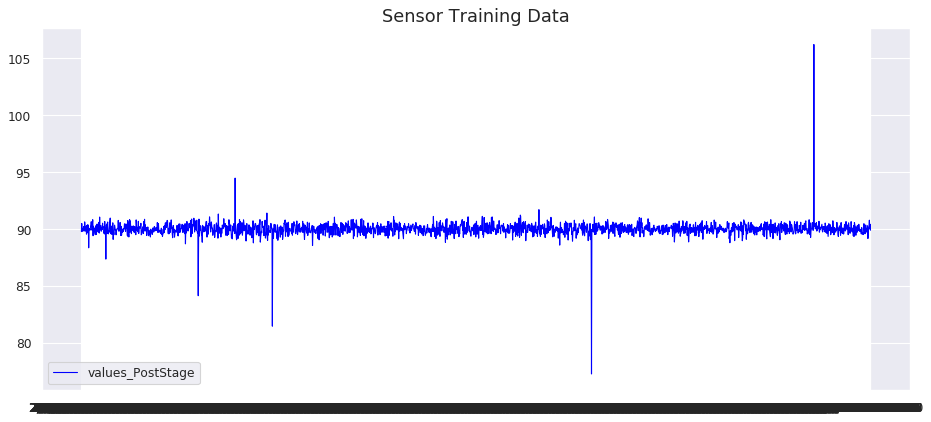

In [20]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['values_PostStage'], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

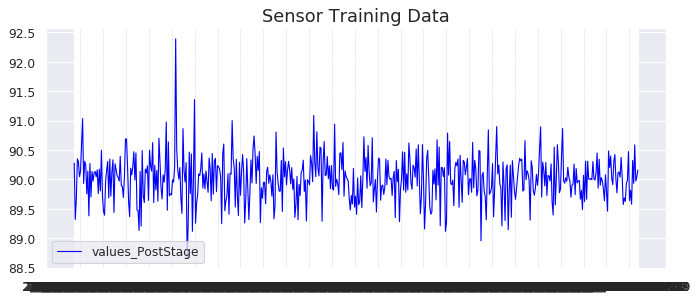

In [21]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)
ax.plot(val['values_PostStage'], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

In [0]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
val_fft = np.fft.fft(val)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


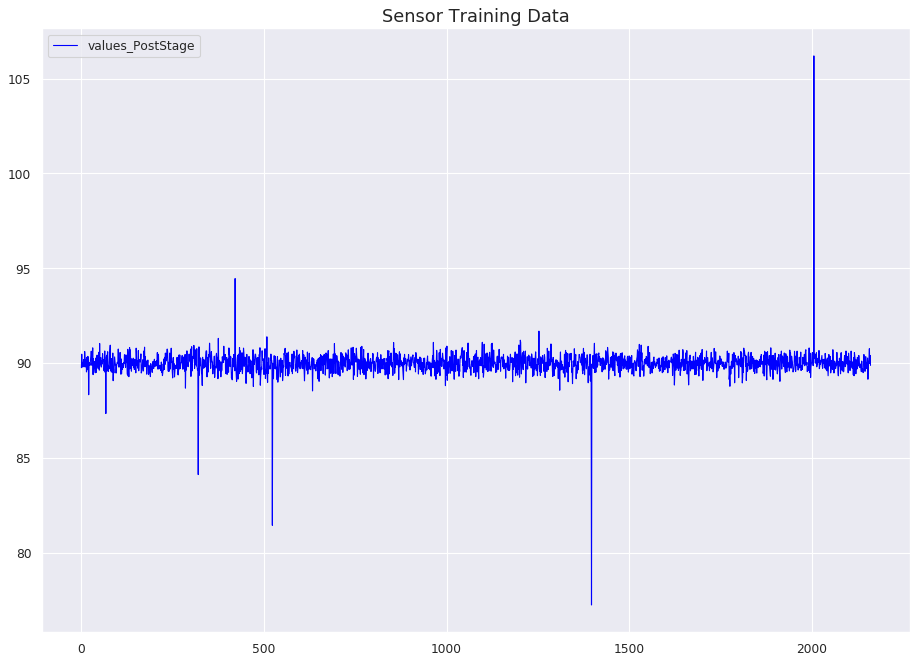

In [23]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(train_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='top left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


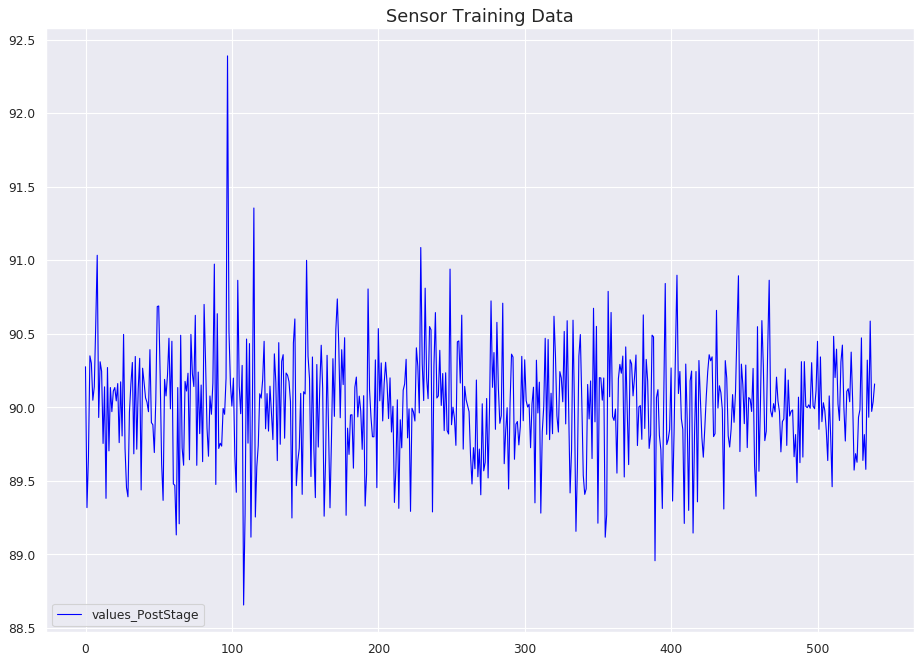

In [24]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(val_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

In [25]:
# first normalize it to a range between 0 and 1.
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_val = scaler.transform(val)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [26]:
X_train.shape

(2162, 1)

In [27]:
X_val.shape

(540, 1)

In [28]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)

Training data shape: (2162, 1, 1)
Test data shape: (540, 1, 1)


In [0]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [30]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              17    

In [31]:
# fit the model to the data
nb_epochs = 30
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 2053 samples, validate on 109 samples
Epoch 1/30
2053/2053 [==============================] - 5s 3ms/sample - loss: 0.4258 - val_loss: 0.4085
Epoch 2/30
2053/2053 [==============================] - 0s 68us/sample - loss: 0.3934 - val_loss: 0.3745
Epoch 3/30
2053/2053 [==============================] - 0s 54us/sample - loss: 0.3575 - val_loss: 0.3361
Epoch 4/30
2053/2053 [==============================] - 0s 59us/sample - loss: 0.3164 - val_loss: 0.2916
Epoch 5/30
2053/2053 [==============================] - 0s 56us/sample - loss: 0.2682 - val_loss: 0.2383
Epoch 6/30
2053/2053 [==============================] - 0s 57us/sample - loss: 0.2093 - val_loss: 0.1715
Epoch 7/30
2053/2053 [==============================] - 0s 56us/sample - loss: 0.1330 - val_loss: 0.0812
Epoch 8/30
2053/2053 [==============================] - 0s 76us/sample - loss: 0.0370 - val_loss: 0.0206
Epoch 9/30
2053/2053 [==============================] - 0s 63us/sample - loss: 0.0137 - val_loss: 0.0089
Epoch 10/

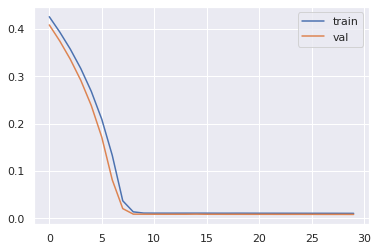

In [32]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend();

In [0]:
# Finding Anomalies
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

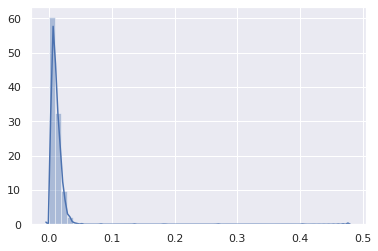

In [34]:
# look at the error:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
THRESHOLD = 0.03

In [0]:
# Let’s calculate the MAE on the test data:
X_val_pred = model.predict(X_val)

val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=1)

In [0]:
# We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):
val_score_df = pd.DataFrame(index=val.index)
val_score_df['loss'] = val_mae_loss
val_score_df['threshold'] = THRESHOLD
val_score_df['anomaly'] = val_score_df.loss > val_score_df.threshold
val_score_df['values_PostStage'] = val.values_PostStage

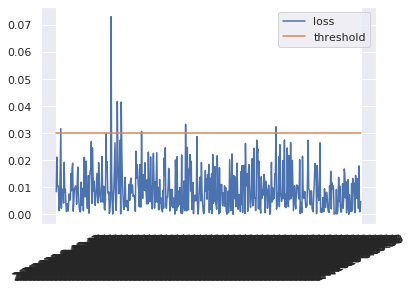

In [38]:
plt.plot(val_score_df.index, val_score_df.loss, label='loss')
plt.plot(val_score_df.index, val_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [39]:
# Looks like we’re thresholding extreme values quite well. Let’s create a DataFrame using only those:
anomalies = val_score_df[val_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,values_PostStage
Timestamp_HR,,,,
2/7/2020 9:46:49,0.031663,0.03,True,91.033530
2/7/2020 9:48:18,0.073074,0.03,True,92.389246
2/7/2020 9:48:29,0.041717,0.03,True,88.655663
2/7/2020 9:48:36,0.041509,0.03,True,91.354925
2/7/2020 9:49:12,0.030605,0.03,True,90.999040


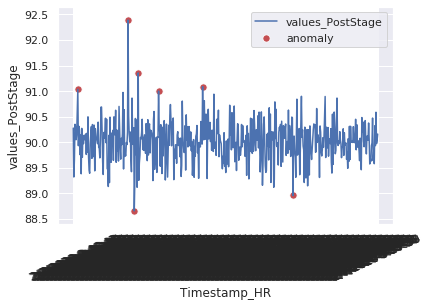

In [40]:
plt.plot(
  val.index, 
  val.values_PostStage, 
  label='values_PostStage'
);

sns.scatterplot(
  anomalies.index,
  anomalies.values_PostStage,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();